# UDLR Two Dimentional Vision System Examples

In [2]:
import numpy as np
from pyESN import ESN
from matplotlib import pyplot as plt
%matplotlib inline
import csv
import networkx as nx
import networkx as nx
from matplotlib import pyplot, patches

from utils import *

In [3]:
def generate_liquid(n_inputs):
    G = generate_ffbo_graph()
    n_reservoir = G.number_of_nodes()

    # Create Input Matrix
    input_matrix = np.zeros((n_reservoir, n_inputs))
    for j,c in enumerate(names):
        for i,n in enumerate(G.nodes()):
            if 'L1' in n or  'L2' in n or  'L4' in n:
                if c in n:
                input_matrix[i,j] = 1                

    #Create a list of network outputs that can be used to train upon
    # We focus oon the T4 and Tm* neurons
    output_node_matrix = np.zeros((input_matrix.shape[0],input_matrix.shape[1]))

    for i,n in enumerate(G.nodes()):
        if 'Tm3' in n or 'Mi1' in n or 'Mi9' in n or 'Mi4' in n or 'T4' in n:    
            output_node_matrix[1,:] = 1
            
    adjacency_matrix = np.array(nx.adjacency_matrix(G, weight='weight').todense())
    adjacency_matrix[matrix>0] = 1
    adjacency_matrix[matrix<1] = 0

    return adjacency_matrix,input_matrix,output_node_matrix
            


IndentationError: expected an indented block (<ipython-input-3-9e5f3f148810>, line 11)

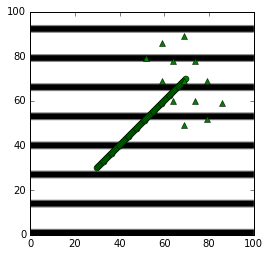

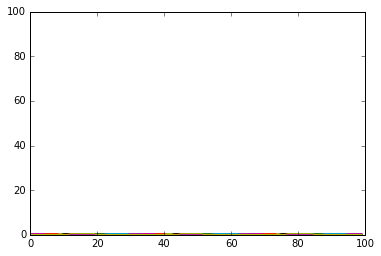

In [21]:
def bars_signal(n=100,on_size=10,off_size=10,on_val=1,off_val=0):
    image = np.zeros((n,n))
    
    i = 0
    while i < n:
        image[i:i+on_size] = on_val
        i = i+on_size
        image[i:i+off_size] = off_val
        i = i+off_size
    
    return image

def single_trial(image, centers,input_class,hex_radius =0.1):

    input_data = []
    input_class = np.array([input_class for _ in centers])
    
    for m in centers:
        ps,d,names = extract_data(image,(2,2),m, hex_radius)
        input_data.append(d)

    return np.array(input_data), input_class, ps, names



#image = bars_signal(n=100)
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)


def generate_centers(trial_length = 100,path_start = 0.3,path_end = 0.7):
    path_steps = (path_end-path_start)/trial_length
    centers = [(n,n) for n in np.arange(path_start,path_end,path_steps)]
    return centers


trial_length = 100
centers = generate_centers(trial_length)

data, classes, ps, names = single_trial(image, centers,input_class=0,hex_radius =0.1)

plt.imshow(-image,cmap='gray')
for c in centers:
    plt.plot(c[0]*100,c[1]*100,'go')
plt.plot(ps[0,:],ps[1,:],'g^')

plt.ylim(0,100)
plt.xlim(0,100)

plt.savefig('bar_input.png',bbox='tight')

plt.show()

for d in data.T:
    plt.plot(d)

plt.ylim(0,100)
plt.show()


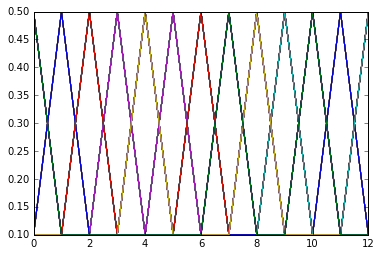

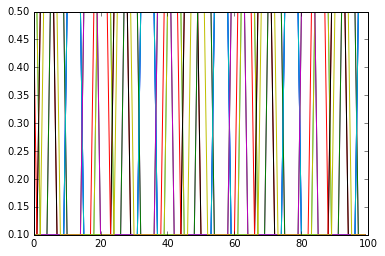

In [5]:
for i,_ in enumerate(centers):
    plt.plot(data[i,:])
plt.show()

for i in np.arange(13):
    plt.plot(data[:,i])
plt.show()


In [5]:
#image = bars_signal(n=100,on_size=10,off_size=30,on_val = 0.5,off_val = 0.1)
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)

trial_length = 100

# Move X directions
centers[0] = generate_centers(trial_length)
# Move Y directions
centers[1] = generate_centers(trial_length)#[(y,x) for (x,y) in generate_centers(trial_length)]
# Move X directions
centers[2] = generate_centers(trial_length)
centers[2].reverse()
# Move Y directions
centers[3] = generate_centers(trial_length)#[(y,x) for (x,y) in generate_centers(trial_length)]
centers[3].reverse()

images = {}

n_outputs = 4
n_trials = n_outputs *30

trials = []
t = 0
for i in np.arange(n_trials):
    trials.append(t)
    t+=1
    if t == n_outputs:t=0

from random import shuffle

shuffle(trials)

        
trial_data = []
trial_class = []
image_backup = image.copy()

for trial in trials:
    cs = centers[trial]
    
    if trial == 1  or trial == 3: 
        image = image_backup.T.copy()
    else:
        image = image_backup.copy()
    images[trial] = image
    data, classes, ps, names = single_trial(image, cs,input_class=trial,hex_radius =0.03)
    
    trial_data.append(data)
    trial_class.append(classes)


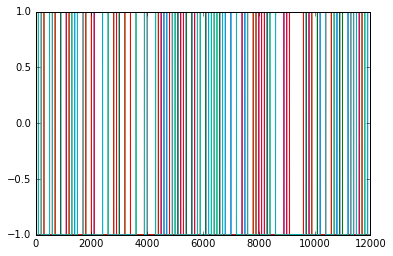

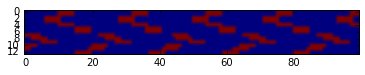

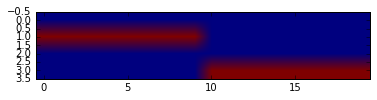

In [6]:
experiment_classes = np.hstack(trial_class)

experiment_targets= -np.ones((n_outputs,experiment_classes.shape[0]))
for i,c in enumerate(experiment_classes):
    experiment_targets[c,i] = 1

experiment_data = np.ones((trial_data[0].shape[0]*len(trial_data),trial_data[0].shape[1]))

for i,d in enumerate(trial_data):
    experiment_data[i*trial_data[0].shape[0]:(i+1)*trial_data[0].shape[0],:] = d

experiment_data = experiment_data.T

for i in np.arange(n_outputs):
    plt.plot(experiment_targets[i,:]);
plt.show()

plt.imshow(experiment_data[:,0:100]); plt.show()
plt.imshow(experiment_targets[0:4,90:110]); plt.show()

Using Matrix
Using Input Matrix
state shape [12000, 434]
state shape after [12000, 434]


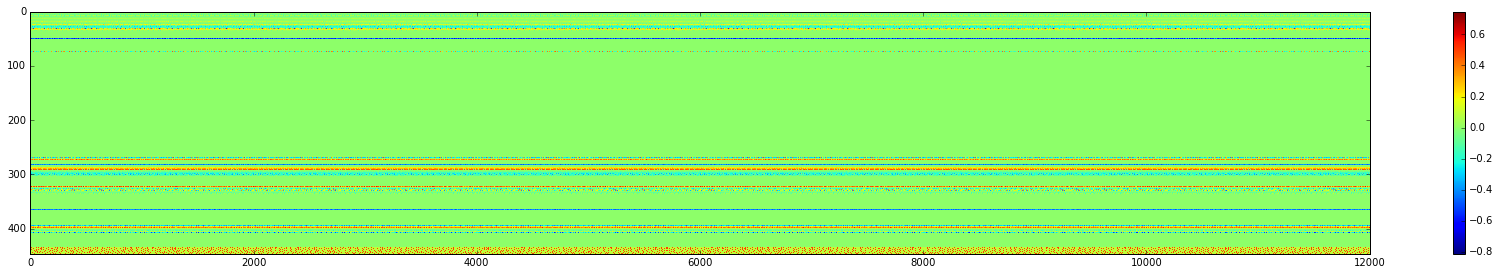

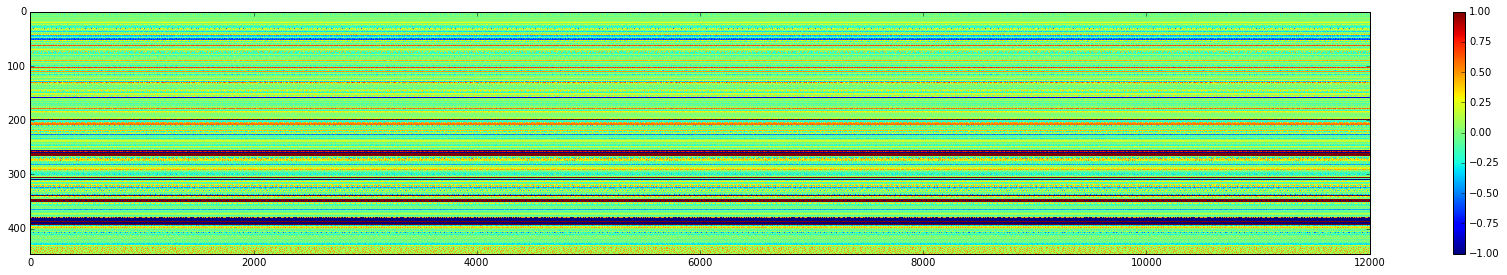

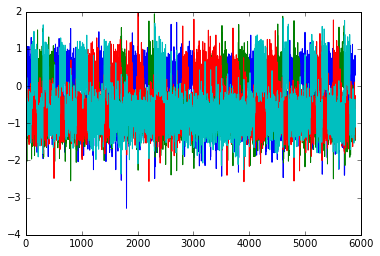

In [16]:
trainlen = experiment_targets.shape[1]/2
future =  experiment_targets.shape[1]/2
full = trainlen + future

# Simulation Data
n_reservoir =G.number_of_nodes()
n_inputs =len(names)

matrix = np.array(nx.adjacency_matrix(G, weight='weight').todense())
matrix[matrix>0] = 1
matrix[matrix<1] = 0

# Create Input Matrix
input_matrix = np.zeros((n_reservoir, n_inputs))
for j,c in enumerate(names):
    for i,n in enumerate(G.nodes()):
        if 'L1' in n or  'L2' in n or  'L4' in n:
            if c in n:
                input_matrix[i,j] = 1                

#input_matrix = np.zeros((n_reservoir, n_inputs))
                
esn = ESN(n_inputs = n_inputs,
          n_outputs = n_outputs,
          n_reservoir = n_reservoir,
          spectral_radius = 1.05,
          #noise = 0.01,
          random_state=42,
          teacher_forcing=False,
          matrix=matrix,
          input_matrix = input_matrix*100
          )

#Create a list of network outputs that can be used to train upon
# We focus oon the T4 and Tm* neurons
o_nodes = np.zeros((input_matrix.shape[1],input_matrix.shape[0]))



for i,n in enumerate(G.nodes()):
    if 'Tm3' in n or 'Mi1' in n or 'Mi9' in n or 'Mi4' in n or 'T4' in n:    
        o_nodes[:,i] = 1
        

o_nodes = o_nodes[0,:].T
#o_nodes = None

# Fit the network        
pred_training = esn.fit(experiment_data[:trainlen].T,experiment_targets[:trainlen].T,True,o_nodes)

# Generate Output
prediction = esn.predict(experiment_data[:,trainlen:trainlen+future].T)

plt.show()
plt.plot(prediction[100:])
plt.show()

In [17]:
prediction_classes = np.array(trials[-(len(trials)/2):])
#prediction_classes = prediction_classes[2:]

classes = np.arange(n_outputs)

results = {c:{o: [] for o in classes} for c in classes }

for i,c in enumerate(prediction_classes):
    tc = c

    data = prediction[i*trial_length:(i*trial_length)+trial_length,:]

    for cl in classes:
        results[tc][cl].append(sum(data[:,cl]))
  
def analise_results(results):
    for c in results:
        target = results[c][c]
        others = set(results[c].keys())
        others.remove(c)
        
        other_data = np.vstack([results[c][d] for d in others])
        ratio =  sum(target > np.max(other_data)) / (len(target)*1.0)
    return ratio
    
    
print analise_results(results)

1.0


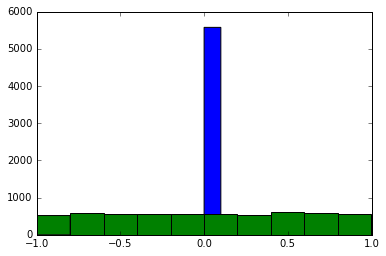

(array([8.000e+00, 5.000e+00, 4.000e+00, 5.000e+00, 5.583e+03, 4.000e+00,
        7.000e+00, 7.000e+00, 5.000e+00, 1.400e+01]),
 array([-0.93102562, -0.73840146, -0.5457773 , -0.35315313, -0.16052897,
         0.03209519,  0.22471935,  0.41734351,  0.60996767,  0.80259183,
         0.99521599]),
 <a list of 10 Patch objects>)

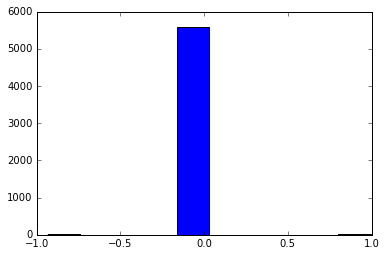

In [18]:
plt.hist(input_matrix.flatten())
r = esn.random_state_.rand(esn.n_reservoir,esn.n_inputs) * 2 - 1
x = r* input_matrix
plt.hist(r.flatten())
plt.show()
plt.hist(x.flatten())